In [ ]:
#laos data viz!

In [1]:
#path configuration
to_data_parent = "../USAID-Laos-EV" #path to the parent folder, should contain program subfolders
to_data_folder = "../USAID-Laos-EV" #data folder, where composite data files will be written/read

program = "usaid_laos_ev"

In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model

sns.set_style("whitegrid")
sns.set()
%matplotlib inline

params = {'legend.fontsize': 'small',
          'figure.figsize': (10, 8),
         'axes.labelsize': 'small',
         'axes.titlesize':'small',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
plt.rcParams.update(params)


import importlib

In [4]:
print('starting with ', program)

#create dataset with surveys and trips
print(to_data_parent + '/' + program + '_trips.csv')
trips = pd.read_csv(to_data_parent + '/' + program + '_trips.csv')
print(len(trips), 'trips')
print(trips.user_id.nunique(), 'people')

surveys = pd.read_csv(to_data_parent + '/' + program + '_demographics.csv')
print(len(surveys), 'surveys')

#drop any null ids
socio_data = surveys[~surveys['user_id'].isnull()]
print(len(socio_data), 'surveys after dropping null ids')

#drop duplicates
socio_data = socio_data.sort_values(by=['user_id', 'data.ts'])
socio_data.drop_duplicates(subset=['user_id'], keep='last', inplace=True)
print(len(socio_data),'surveys', socio_data['user_id'].nunique(), 'users after dropping duplicates')

#prepare survey ids for merging
socio_data['user_id_socio'] = socio_data['user_id'].astype(str)
socio_data['user_id_socio'] = socio_data['user_id_socio'].str.strip() #remove leading or trailing whitespace!!
socio_data['user_id_socio'] = [i.replace('-','') for i in socio_data.user_id_socio]
socio_data['user_id_socio'] = socio_data['user_id_socio']
socio_data = socio_data.drop(labels='user_id', axis=1)


#prepare trip ids for merging
trips['user_id_socio'] = trips.user_id.astype(str)
trips['user_id_socio'] = trips['user_id_socio'].str.strip() #remove leading or trailing whitespace!!
trips.user_id_socio = [i.replace('-','') for i in trips.user_id_socio] # remove all dashes from strings

#merge the data
data = trips.merge(socio_data, on='user_id_socio')
print(len(data), 'trips after merging')
print(data.user_id_socio.nunique(), 'people after merging')

data.rename(columns={'data.distance_km':'data.distance'}, inplace=True)

data['program'] = program

starting with  usaid_laos_ev
../USAID-Laos-EV/usaid_laos_ev_trips.csv
7565 trips
24 people
27 surveys
27 surveys after dropping null ids
24 surveys 24 users after dropping duplicates
6706 trips after merging
22 people after merging


In [5]:
#merge them all together
full_data = data.copy()
print(len(full_data), 'trips')
print(full_data.user_id.nunique(), 'users')

full_data.to_csv(to_data_folder + "/expanded_ct.csv")

6706 trips
22 users


In [6]:
# loading the data
data = pd.read_csv(to_data_folder + "/expanded_ct.csv")
data.columns

Index(['Unnamed: 0', 'data.start_fmt_time', 'data.end_fmt_time', 'user_id',
       'data.duration', 'mode_confirm', 'purpose_confirm', 'data.distance',
       'user_id_socio', '_id', 'data.ts', 'At_your_primary_job_do_you_ha',
       'Which_best_describes_your_prim', 'Do_you_work_full_time_or_part_',
       'Do_you_have_the_option_of_work', 'Please_describe_your_primary_job',
       'Do_you_have_more_than_one_job', 'What_days_of_the_week_do_you_t',
       'How_many_days_do_you_usually_w_001', 'Which_one_below_describe_you_b',
       'What_is_your_race_ethnicity', 'Are_you_a_student',
       'What_is_the_highest_grade_or_d', 'do_you_consider_yourself_to_be',
       'What_is_your_gender', 'How_old_are_you', 'Are_you_a_paid_worker',
       'Do_you_have_a_driver_license', 'How_long_you_had_this_conditio',
       'Including_yourself_how_many_w_001', 'Including_yourself_how_many_p',
       'Do_you_own_or_rent_your_home', 'Please_identify_which_category',
       'How_many_motor_vehicles_are_o

In [7]:
unique_values = trips['mode_confirm'].unique()

# Print out the unique values
for value in unique_values:
    print(value)


nan
drove_alone
e_car_drove_alone
shared_ride
motorcycle
e-auto_rickshaw
e-bike
walk
taxi
e_car_shared_ride
bike
auto_rickshaw
air
not_a_trip


In [8]:
# Summary statistics table
print(len(pd.unique(data.user_id)))
stat_data = data[['data.distance_km','data.duration']]
stat_data.describe()

22


KeyError: "['data.distance_km'] not in index"

In [ ]:
# Group by user_id and count the number of trips
user_trip_counts = full_data.groupby('user_id').size()

# Create a new DataFrame with user_id as index and trip counts as columns
table_data = pd.DataFrame(user_trip_counts, columns=['Total Number of Trips'])

# Calculate total number of users and total number of trips
total_users = len(table_data)
total_trips = table_data['Total Number of Trips'].sum()

# Rename user_ids to unique names
user_id_map = {user_id: f'User {i+1}' for i, user_id in enumerate(table_data.index)}
table_data.rename(index=user_id_map, inplace=True)

sorted_table_data = table_data.sort_values(by='Total Number of Trips')


# Plot the bar plot
plt.figure(figsize=(10, 6))
plt.bar(sorted_table_data.index, sorted_table_data['Total Number of Trips'], color='skyblue')
plt.xlabel('Users')
plt.ylabel('Total Number of Trips')
plt.title('User Trip Counts')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Add a row for total users and total trips
table_data.loc['Total'] = [total_trips]

# Plot the table
plt.figure(figsize=(2, 6))
plt.table(cellText=table_data.values,
          colLabels=table_data.columns,
          rowLabels=table_data.index,
          loc='center')
plt.axis('off')
plt.title('User Trip Counts')
plt.show()


In [ ]:
# Function to categorize slices into "other" if percentage is less than limit%
def categorize_into_other(grouped_data, limit):
    total_count = grouped_data['count'].sum()
    grouped_data['percentage'] = (grouped_data['count'] / total_count) * 100
    other_slice = grouped_data[grouped_data['percentage'] < limit]
    other_count = other_slice['count'].sum()
    grouped_data = grouped_data[grouped_data['percentage'] >= limit]
    if other_count > 0:
        grouped_data = grouped_data.append({'purpose_confirm': 'Other', 'count': other_count}, ignore_index=True)
    return grouped_data

In [9]:
# Filter the dataframe to include only rows where "purpose_confirm" is not null
purposes_data = full_data[full_data['purpose_confirm'].notnull()]

# Count the number of rows in the filtered dataframe
purposes_plot_data = purposes_data.groupby('purpose_confirm').size().reset_index(name='count')

# Remove purposes that represent < 2% of the overall, to not dilute the room on the chart
purposes_plot_data = categorize_into_other(purposes_plot_data, 2)

purposes_plot_data['purpose_confirm'] = purposes_plot_data['purpose_confirm'].replace({'work': 'Work'})
purposes_plot_data['purpose_confirm'] = purposes_plot_data['purpose_confirm'].replace({'at_work': 'At Work'})
purposes_plot_data['purpose_confirm'] = purposes_plot_data['purpose_confirm'].replace({'meal': 'Meal'})
purposes_plot_data['purpose_confirm'] = purposes_plot_data['purpose_confirm'].replace({'pick_drop_person': 'Pick up/ Drop off Person'})
purposes_plot_data['purpose_confirm'] = purposes_plot_data['purpose_confirm'].replace({'school': 'School'})

# Create a pie chart
plt.figure(figsize=(8, 8))  # Adjust the figure size as needed
plt.pie(purposes_plot_data['count'], labels=purposes_plot_data['purpose_confirm'], autopct=lambda p: '{:.1f}%\n({:.0f})'.format(p, p * sum(purposes_plot_data['count']) / 100), startangle=140)

# Set the title
plt.title('Distribution of Labeled Trip Purposes')

# Show the plot
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

NameError: name 'categorize_into_other' is not defined

In [10]:
# Filter the dataframe for gender "man"
man_data = full_data[full_data['What_is_your_gender'] == 'man']

# Group the dataframe by "purpose_confirm" for "man" and count the number of rows for each group
purposes_man_data = man_data.groupby('purpose_confirm').size().reset_index(name='count')

# Filter out slices with less than 4% of the total count
purposes_man_data = categorize_into_other(purposes_man_data, 4)

purposes_man_data['purpose_confirm'] = purposes_man_data['purpose_confirm'].replace({'work': 'Work'})
purposes_man_data['purpose_confirm'] = purposes_man_data['purpose_confirm'].replace({'at_work': 'At Work'})
purposes_man_data['purpose_confirm'] = purposes_man_data['purpose_confirm'].replace({'meal': 'Meal'})
purposes_man_data['purpose_confirm'] = purposes_man_data['purpose_confirm'].replace({'pick_drop_person': 'Pick up/ Drop off Person'})
purposes_man_data['purpose_confirm'] = purposes_man_data['purpose_confirm'].replace({'school': 'School'})
purposes_man_data['purpose_confirm'] = purposes_man_data['purpose_confirm'].replace({'home': 'Home'})
purposes_man_data['purpose_confirm'] = purposes_man_data['purpose_confirm'].replace({'shopping': 'Shopping'})

colors_man = ['steelblue', 'coral', 'mediumpurple', 'darkgoldenrod', 'plum', 'cyan', 'magenta', 'yellow']

# Create a pie chart for "man"
plt.figure(figsize=(8, 8))  # Adjust the figure size as needed
plt.pie(purposes_man_data['count'], labels=purposes_man_data['purpose_confirm'], autopct=lambda p: '{:.1f}%\n({:.0f})'.format(p, p * sum(purposes_man_data['count']) / 100), startangle=140, colors=colors_man)
plt.title('[Men] Distribution of Labeled Trip Purposes')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

NameError: name 'categorize_into_other' is not defined

1272 trips
16 people


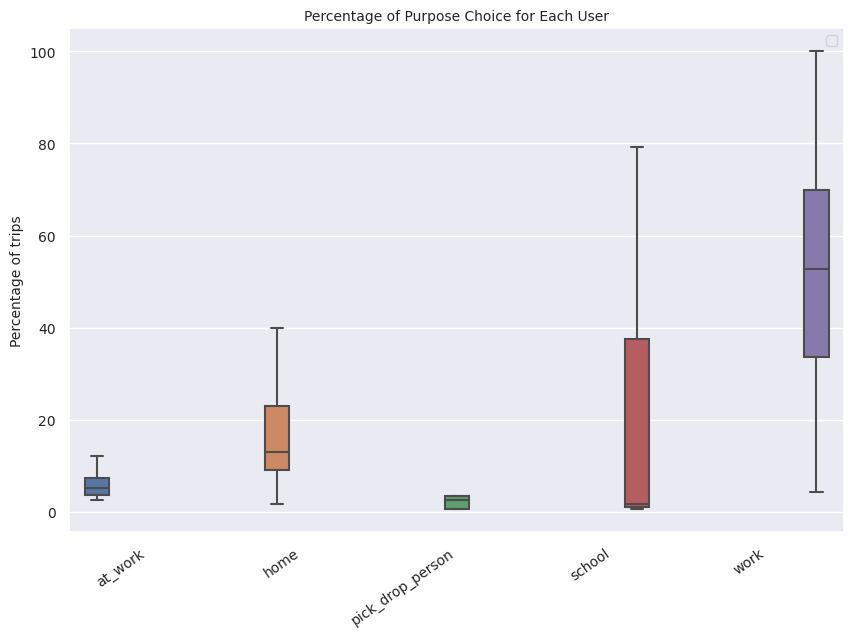

In [33]:
print(full_data['purpose_confirm'].dropna().size, "trips")
# Grouping the data by user and purpose_confirm and calculating the count for each group
grouped_data = full_data.groupby(['user_id', 'purpose_confirm']).size().reset_index(name='count')

grouped_data = grouped_data.sort_values(by=['purpose_confirm'])

# Grouping the DataFrame by 'user_id'
grouped_df = grouped_data.groupby('user_id')

# Calculate the total count of trips for each user
total_trips = grouped_df['count'].transform('sum')

# Calculate the percentage of each purpose_confirm for each user
grouped_data['percentage'] = (grouped_data['count'] / total_trips) * 100
grouped_data.head(50)

#grouped_data = grouped_data[grouped_data['purpose_confirm']=='work' | grouped_data['purpose_confirm']=='at_work' | grouped_data['purpose_confirm']=='pick_drop_person']
grouped_data = grouped_data.query('purpose_confirm=="work" | purpose_confirm=="school" | purpose_confirm=="at_work" | purpose_confirm=="pick_drop_person" | purpose_confirm=="home"')

# Plotting the box and whisker plot
fig, ax = plt.subplots(figsize=(10,8))
plot_title = 'Percentage of Purpose Choice for Each User'
ylab = 'Percentage of trips'
sns.boxplot(ax=ax, data=grouped_data, x='purpose_confirm', y='percentage', hue='purpose_confirm', showfliers=False).set(title=plot_title, xlabel='', ylabel=ylab)

plt.subplots_adjust(bottom=0.25)
plt.xticks(rotation=35, ha='right')
plt.legend([])

print(grouped_data['user_id'].nunique(), "people")

1270 trips
14 people


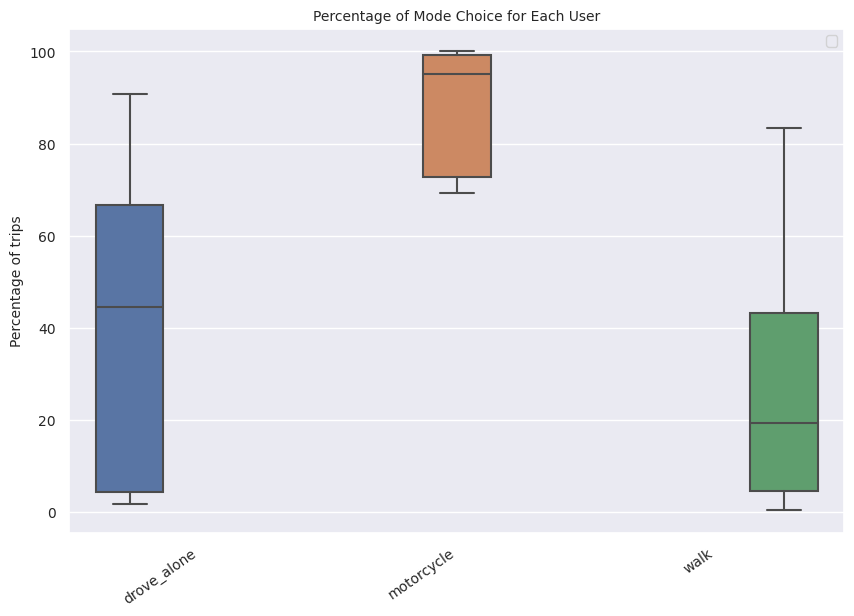

In [49]:
print(full_data['mode_confirm'].dropna().size, "trips")
# Grouping the data by user and purpose_confirm and calculating the count for each group
grouped_data = full_data.groupby(['user_id', 'mode_confirm']).size().reset_index(name='count')

grouped_data = grouped_data.sort_values(by=['mode_confirm'])

# Grouping the DataFrame by 'user_id'
grouped_df = grouped_data.groupby('user_id')

# Calculate the total count of trips for each user
total_trips = grouped_df['count'].transform('sum')

# Calculate the percentage of each purpose_confirm for each user
grouped_data['percentage'] = (grouped_data['count'] / total_trips) * 100
grouped_data.head(50)

#grouped_data = grouped_data[grouped_data['purpose_confirm']=='work' | grouped_data['purpose_confirm']=='at_work' | grouped_data['purpose_confirm']=='pick_drop_person']
grouped_data = grouped_data.query('mode_confirm=="walk" | mode_confirm=="drove_alone" | mode_confirm=="motorcycle"')

# Plotting the box and whisker plot
fig, ax = plt.subplots(figsize=(10,8))
plot_title = 'Percentage of Mode Choice for Each User'
ylab = 'Percentage of trips'
sns.boxplot(ax=ax, data=grouped_data, x='mode_confirm', y='percentage', hue='mode_confirm', showfliers=False).set(title=plot_title, xlabel='', ylabel=ylab)

plt.subplots_adjust(bottom=0.25)
plt.xticks(rotation=35, ha='right')
plt.legend([])

print(grouped_data['user_id'].nunique(), "people")

455 trips
8 men


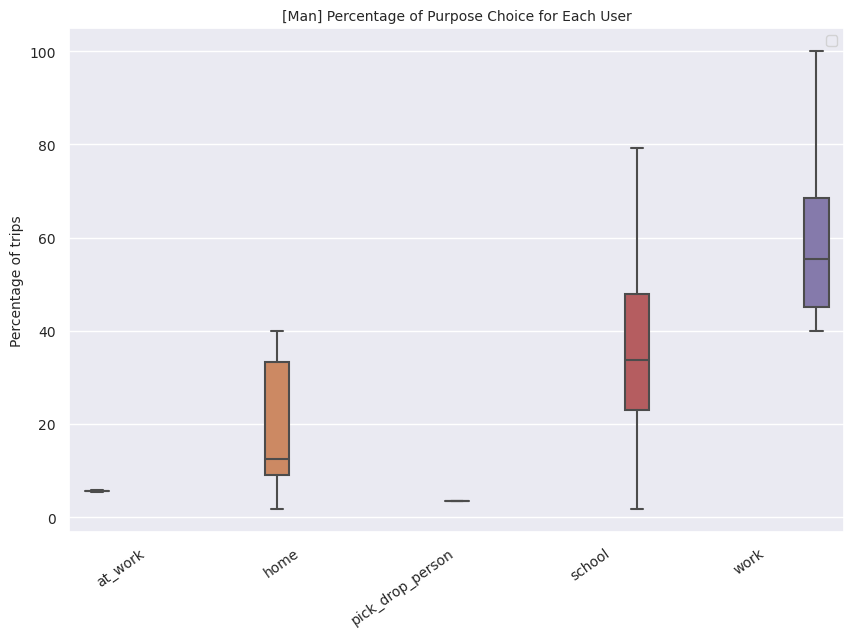

In [50]:
men_full_data = full_data[full_data['What_is_your_gender'] == 'man']

print(men_full_data['purpose_confirm'].dropna().size, "trips")
# Grouping the data by user and purpose_confirm and calculating the count for each group
grouped_data = men_full_data.groupby(['user_id', 'purpose_confirm']).size().reset_index(name='count')

grouped_data = grouped_data.sort_values(by=['purpose_confirm'])

# Grouping the DataFrame by 'user_id'
grouped_df = grouped_data.groupby('user_id')

# Calculate the total count of trips for each user
total_trips = grouped_df['count'].transform('sum')

# Calculate the percentage of each purpose_confirm for each user
grouped_data['percentage'] = (grouped_data['count'] / total_trips) * 100
grouped_data.head(50)

#grouped_data = grouped_data[grouped_data['purpose_confirm']=='work' | grouped_data['purpose_confirm']=='at_work' | grouped_data['purpose_confirm']=='pick_drop_person']
grouped_data = grouped_data.query('purpose_confirm=="work" | purpose_confirm=="school" | purpose_confirm=="at_work" | purpose_confirm=="pick_drop_person" | purpose_confirm=="home"')

# Plotting the box and whisker plot
fig, ax = plt.subplots(figsize=(10,8))
plot_title = '[Man] Percentage of Purpose Choice for Each User'
ylab = 'Percentage of trips'
sns.boxplot(ax=ax, data=grouped_data, x='purpose_confirm', y='percentage', hue='purpose_confirm', showfliers=False).set(title=plot_title, xlabel='', ylabel=ylab)

plt.subplots_adjust(bottom=0.25)
plt.xticks(rotation=35, ha='right')
plt.legend([])
print(grouped_data['user_id'].nunique(), "men")

456 trips
8 men


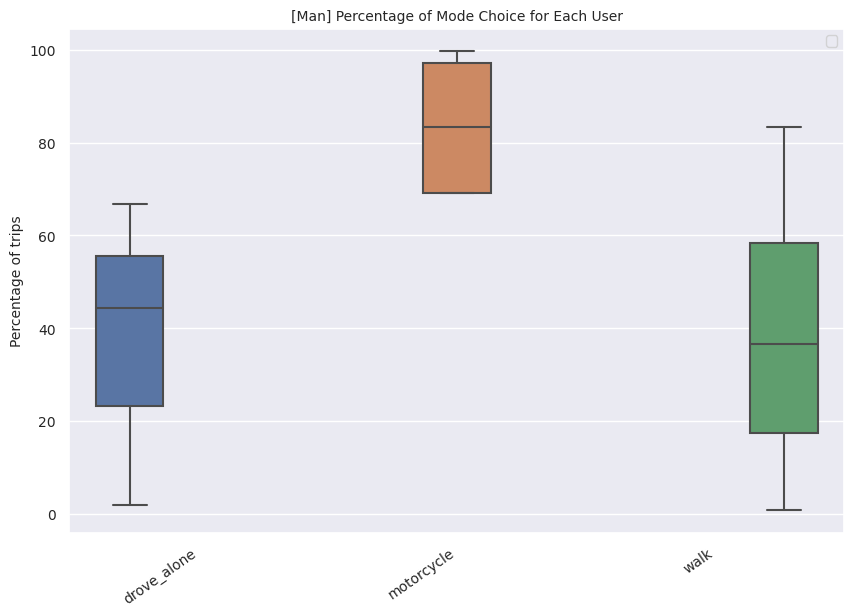

In [51]:
men_full_data = full_data[full_data['What_is_your_gender'] == 'man']

print(men_full_data['mode_confirm'].dropna().size, "trips")
# Grouping the data by user and purpose_confirm and calculating the count for each group
grouped_data = men_full_data.groupby(['user_id', 'mode_confirm']).size().reset_index(name='count')

grouped_data = grouped_data.sort_values(by=['mode_confirm'])

# Grouping the DataFrame by 'user_id'
grouped_df = grouped_data.groupby('user_id')

# Calculate the total count of trips for each user
total_trips = grouped_df['count'].transform('sum')

# Calculate the percentage of each purpose_confirm for each user
grouped_data['percentage'] = (grouped_data['count'] / total_trips) * 100
grouped_data.head(50)

#grouped_data = grouped_data[grouped_data['purpose_confirm']=='work' | grouped_data['purpose_confirm']=='at_work' | grouped_data['purpose_confirm']=='pick_drop_person']
grouped_data = grouped_data.query('mode_confirm=="motorcycle" | mode_confirm=="walk" | mode_confirm=="drove_alone"')

# Plotting the box and whisker plot
fig, ax = plt.subplots(figsize=(10,8))
plot_title = '[Man] Percentage of Mode Choice for Each User'
ylab = 'Percentage of trips'
sns.boxplot(ax=ax, data=grouped_data, x='mode_confirm', y='percentage', hue='mode_confirm', showfliers=False).set(title=plot_title, xlabel='', ylabel=ylab)

plt.subplots_adjust(bottom=0.25)
plt.xticks(rotation=35, ha='right')
plt.legend([])
print(grouped_data['user_id'].nunique(), "men")

817 trips
8 women


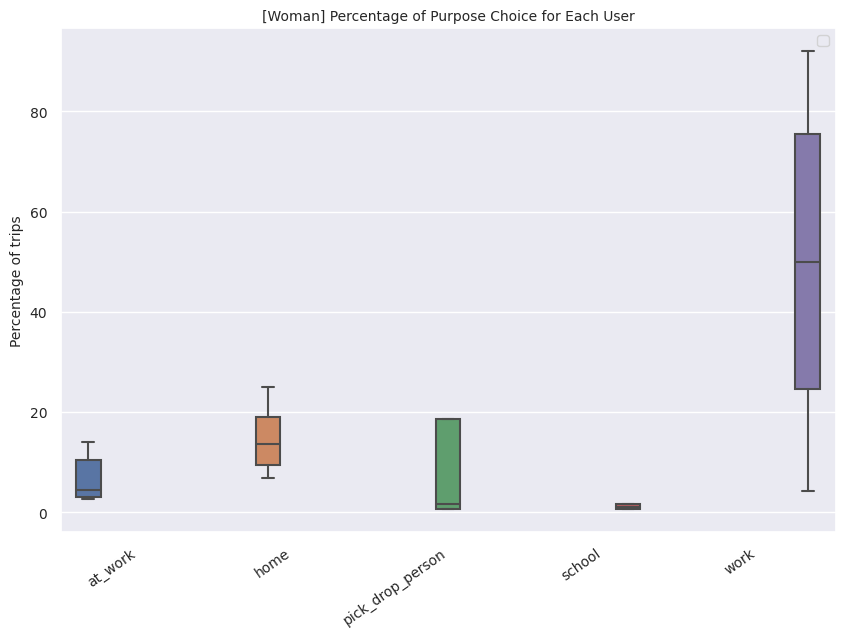

In [37]:
women_full_data = full_data[full_data['What_is_your_gender'] == 'woman']

print(women_full_data['purpose_confirm'].dropna().size, "trips")
# Grouping the data by user and purpose_confirm and calculating the count for each group
grouped_data = women_full_data.groupby(['user_id', 'purpose_confirm']).size().reset_index(name='count')

grouped_data = grouped_data.sort_values(by=['purpose_confirm'])

# Grouping the DataFrame by 'user_id'
grouped_df = grouped_data.groupby('user_id')

# Calculate the total count of trips for each user
total_trips = grouped_df['count'].transform('sum')

# Calculate the percentage of each purpose_confirm for each user
grouped_data['percentage'] = (grouped_data['count'] / total_trips) * 100
grouped_data.head(50)

#grouped_data = grouped_data[grouped_data['purpose_confirm']=='work' | grouped_data['purpose_confirm']=='at_work' | grouped_data['purpose_confirm']=='pick_drop_person']
grouped_data = grouped_data.query('purpose_confirm=="work" | purpose_confirm=="school" | purpose_confirm=="at_work" | purpose_confirm=="pick_drop_person" | purpose_confirm=="home"')

# Plotting the box and whisker plot
fig, ax = plt.subplots(figsize=(10,8))
plot_title = '[Woman] Percentage of Purpose Choice for Each User'
ylab = 'Percentage of trips'
sns.boxplot(ax=ax, data=grouped_data, x='purpose_confirm', y='percentage', hue='purpose_confirm', showfliers=False).set(title=plot_title, xlabel='', ylabel=ylab)

plt.subplots_adjust(bottom=0.25)
plt.xticks(rotation=35, ha='right')
plt.legend([])

print(grouped_data['user_id'].nunique(), "women")

814 trips
6 women


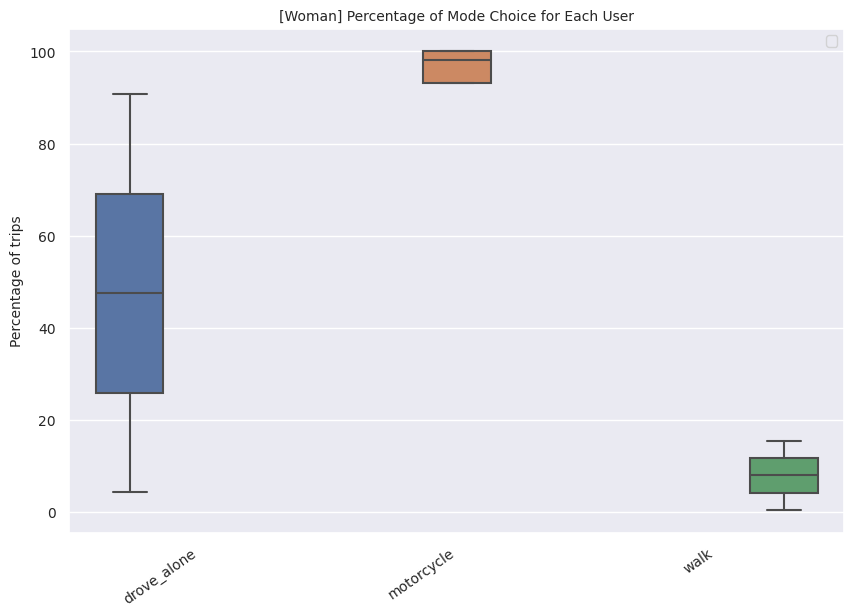

In [47]:
women_full_data = full_data[full_data['What_is_your_gender'] == 'woman']

print(women_full_data['mode_confirm'].dropna().size, "trips")
# Grouping the data by user and purpose_confirm and calculating the count for each group
grouped_data = women_full_data.groupby(['user_id', 'mode_confirm']).size().reset_index(name='count')

grouped_data = grouped_data.sort_values(by=['mode_confirm'])

# Grouping the DataFrame by 'user_id'
grouped_df = grouped_data.groupby('user_id')

# Calculate the total count of trips for each user
total_trips = grouped_df['count'].transform('sum')

# Calculate the percentage of each purpose_confirm for each user
grouped_data['percentage'] = (grouped_data['count'] / total_trips) * 100
grouped_data.head(50)

#grouped_data = grouped_data[grouped_data['purpose_confirm']=='work' | grouped_data['purpose_confirm']=='at_work' | grouped_data['purpose_confirm']=='pick_drop_person']
grouped_data = grouped_data.query('mode_confirm=="motorcycle" | mode_confirm=="walk" | mode_confirm=="drove_alone"')

# Plotting the box and whisker plot
fig, ax = plt.subplots(figsize=(10,8))
plot_title = '[Woman] Percentage of Mode Choice for Each User'
ylab = 'Percentage of trips'
sns.boxplot(ax=ax, data=grouped_data, x='mode_confirm', y='percentage', hue='mode_confirm', showfliers=False).set(title=plot_title, xlabel='', ylabel=ylab)

plt.subplots_adjust(bottom=0.25)
plt.xticks(rotation=35, ha='right')
plt.legend([])
print(grouped_data['user_id'].nunique(), "women")

In [ ]:
# Filter the dataframe for gender "woman"
woman_data = full_data[full_data['What_is_your_gender'] == 'woman']

# Group the dataframe by "purpose_confirm" for "woman" and count the number of rows for each group
purposes_woman_data = woman_data.groupby('purpose_confirm').size().reset_index(name='count')

# Filter out slices with less than 0.5% of the total count
purposes_woman_data = categorize_into_other(purposes_woman_data, 3)

purposes_woman_data['purpose_confirm'] = purposes_woman_data['purpose_confirm'].replace({'work': 'Work'})
purposes_woman_data['purpose_confirm'] = purposes_woman_data['purpose_confirm'].replace({'at_work': 'At Work'})
purposes_woman_data['purpose_confirm'] = purposes_woman_data['purpose_confirm'].replace({'meal': 'Meal'})
purposes_woman_data['purpose_confirm'] = purposes_woman_data['purpose_confirm'].replace({'pick_drop_person': 'Pick up/ Drop off Person'})
purposes_woman_data['purpose_confirm'] = purposes_woman_data['purpose_confirm'].replace({'pick_drop_item': 'Pick up/ Drop off Item'})
purposes_woman_data['purpose_confirm'] = purposes_woman_data['purpose_confirm'].replace({'school': 'School'})
purposes_woman_data['purpose_confirm'] = purposes_woman_data['purpose_confirm'].replace({'home': 'Home'})
purposes_woman_data['purpose_confirm'] = purposes_woman_data['purpose_confirm'].replace({'shopping': 'Shopping'})

colors_woman = ['steelblue', 'coral', 'forestgreen', 'firebrick', 'darkgoldenrod', 'plum', 'magenta', 'yellow']


# Create a pie chart for "man"
plt.figure(figsize=(8, 8))  # Adjust the figure size as needed
plt.pie(purposes_woman_data['count'], labels=purposes_woman_data['purpose_confirm'], autopct=lambda p: '{:.1f}%\n({:.0f})'.format(p, p * sum(purposes_woman_data['count']) / 100), startangle=140, colors=colors_woman)
plt.title('[Women] Distribution of Labeled Trip Purposes')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

In [ ]:
# Group by user_id and count the number of trips
user_labeling_rate = full_data.groupby('user_id').size()

# Calculate the number of trips with non-null/empty mode_confirm for each user
non_null_trips = full_data.dropna(subset=['mode_confirm']).groupby('user_id').size()

# Calculate the percentage of trips with non-null/empty mode_confirm for each user
percentage_non_null = (non_null_trips / user_labeling_rate * 100).fillna(0).round(1)

# Create a new DataFrame with user_id as index and percentage of trips with non-null mode_confirm as a column
table_data = pd.DataFrame({'Percentage of Labeled Trips': percentage_non_null})

table_data['Gender'] = full_data.groupby('user_id')['What_is_your_gender'].first()

# Rename user_ids to unique names
user_id_map = {user_id: f'User {i+1}' for i, user_id in enumerate(table_data.index)}
table_data.rename(index=user_id_map, inplace=True)

# Calculate the average percentage of all non-null values
average_percentage = np.mean(percentage_non_null)

# Calculate average percentage for men and women separately
average_percentage_men = table_data[table_data['Gender'] == 'man']['Percentage of Labeled Trips'].mean()
average_percentage_women = table_data[table_data['Gender'] == 'woman']['Percentage of Labeled Trips'].mean()

# Define color mapping for gender
color_mapping = {'man': 'lightblue', 'woman': 'lightcoral'}

# Create a list of background colors based on gender
cell_colors = [[color_mapping.get(gender, 'white')] * len(table_data.columns) for gender in table_data['Gender']]

# Plot the table with color-coded background
plt.figure(figsize=(4, 6))
plt.table(cellText=table_data.values,
          cellColours=cell_colors,
          colLabels=table_data.columns,
          rowLabels=table_data.index,
          loc='center')
plt.axis('off')
plt.title('Percentage of Labeled Trips by User')

plt.text(0.5, -0.05, f'Average Labeling Percentage Overall: {average_percentage:.1f}%', ha='center', fontsize=10)
plt.text(0.5, -0.1, f'Average Labeling Percentage for Men: {average_percentage_men:.1f}%', ha='center', fontsize=10)
plt.text(0.5, -0.15, f'Average Labeling Percentage for Women: {average_percentage_women:.1f}%', ha='center', fontsize=10)

plt.show()

In [ ]:
full_data['Date'] = full_data['data.start_fmt_time'].str[:10]

# Group the data by date and count the number of total trips on each day
total_trips_per_day = full_data.groupby('Date').size()

# Filter out rows with null/empty mode_confirm values
non_null_trips = full_data.dropna(subset=['mode_confirm'])

# Group the non-null trips by date and count the number of trips on each day
non_null_trips_per_day = non_null_trips.groupby('Date').size()

# Plot the data
plt.figure(figsize=(10, 6))
total_trips_per_day.plot(kind='bar', color='lightgray', label='Total Trips')
non_null_trips_per_day.plot(kind='bar', color='skyblue', label='Labeled Trips')
plt.title('Number of Labeled and Total Trips by Day')
plt.ylabel('Number of Trips')
plt.legend()
plt.xticks(rotation=80)
plt.tight_layout()
plt.show()

In [ ]:
#format the age datapoints for the chart
data = data.replace(['_16_years_old',
              '16___20_years_old',
              '21___25_years_old', 
              '26___30_years_old', 
              '31___35_years_old',
              '36___40_years_old',
              '41___45_years_old', 
              '56___60_years_old'], 
             ['<16',
              '16-20',
              '21-25',
              '26-30',
              '31-35',
              '36-40',
              '41-45',
              '56-60'])

In [ ]:
mode_confirm_counts = data['mode_confirm'].notnull().value_counts()

user_ids_with_mode_confirm = data.loc[data['mode_confirm'].notnull(), 'user_id'].nunique()

# Count the number of unique user_ids that did not have any rows where mode_confirm is not null
user_ids_without_mode_confirm = data.loc[data['mode_confirm'].isnull(), 'user_id'].nunique()



plot_data = pd.DataFrame({
    'Null/Empty': [mode_confirm_counts[False]],
    'Not Null': [mode_confirm_counts[True]]
})

groups = ['Total Trips']
nulls = [mode_confirm_counts[False] + mode_confirm_counts[True]]
notnulls = [mode_confirm_counts[True]]

# Plotting
fig, ax = plt.subplots(figsize=(4,6))
ax.bar(groups, nulls, label = "Unlabeled")
ax.bar(groups, notnulls, label = "Labeled")

for bar in ax.patches:
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2 + bar.get_y(), f'{round(bar.get_height())} labeled trips' if round(bar.get_height()) < 5000 else f'{mode_confirm_counts[False]} unlabeled trips', ha = 'center', color = 'w', weight = 'bold', size = 10)


ax.legend()
ax.set_ylabel('Trips')
    
plt.figure(figsize=(5, 6))
plot_data.plot(kind='bar', stacked=True, color=['blue', 'orange'])
plt.title('Count of Rows with and without Mode Confirm')
plt.xlabel('Mode Confirm')
plt.ylabel('Count of Rows')
plt.xticks([0], [''])  # Hide x-axis labels

plt.legend(title='Mode Confirm', loc='upper right')
plt.tight_layout()
plt.show()


In [ ]:
# Age, Income, Gender
plot_data = data.copy()
plot_data = plot_data.groupby(['user_id']).nth(0)[['How_old_are_you','What_is_your_gender']].dropna()
plot_data = plot_data[plot_data['What_is_your_gender'].isin(['man','woman'])]
plot_data = plot_data.groupby(['user_id'], as_index=False).nth(0)

print(len(plot_data)) #22 participants

#order the values
plot_data['How_old_are_you'] = pd.Categorical(plot_data['How_old_are_you'], [ '<16',
                                                                              '16-20',
                                                                              '21-25',
                                                                              '26-30',
                                                                              '31-35',
                                                                              '36-40',
                                                                              '41-45',
                                                                              '56-60'])

In [ ]:
plot_title='Participant Demographics'
ylab='Count'
file_name='CanBikeCO_report_demog'

fig, axs = plt.subplots(2,2,figsize=(10,6))
sns.histplot(data=plot_data, x='What_is_your_gender', ax=axs[0,0], color='purple', stat='probability').set(xlabel='Sex',ylabel='proportion')
sns.histplot(data=plot_data, x='How_old_are_you', ax=axs[0,1], color='red', stat='probability').set(xlabel='Age',ylabel='proportion')
plt.xticks(rotation=35, ha='right')
plt.tight_layout()

fig.savefig(file_name+".png", bbox_inches='tight')

In [ ]:
#gender - mode correlation
mode_gender_data=data.copy()
mode_gender_data = mode_gender_data[['What_is_your_gender', 'mode_confirm', 'data.distance']]
mode_gender_data = mode_gender_data[mode_gender_data.mode_confirm.notna()]

print(len(mode_gender_data))
mode_gender_data['What_is_your_gender'] = mode_gender_data['What_is_your_gender'].astype('category')
mode_gender_data['mode_confirm'] = mode_gender_data['mode_confirm'].astype('category')

gender_man = mode_gender_data[mode_gender_data['What_is_your_gender'] == 'man']
print(len(gender_man))
gender_woman = mode_gender_data[mode_gender_data['What_is_your_gender'] == 'woman']
print(len(gender_woman))

t1 = gender_man.groupby(['mode_confirm'], as_index=False).count()[['mode_confirm','data.distance']]
t1['proportion'] = t1['data.distance'] / np.sum(t1['data.distance'])
t1['trip_type'] = 'Man'
t1.columns = ['Mode','Count','Proportion','Gender']

# processing long data
t2 = gender_woman.groupby(['mode_confirm'], as_index=False).count()[['mode_confirm','data.distance']]
t2['proportion'] = t2['data.distance'] / np.sum(t2['data.distance'])
t2['trip_type'] = 'Woman'
t2.columns = ['Mode','Count','Proportion','Gender']

plot_data = pd.concat([t1, t2])
plot_data = plot_data.reset_index()
plot_data = plot_data.drop('index', axis='columns')

plot_data

In [ ]:
## code from minipilot vs full pilot regular / commute trip split -- has better labels!!

width = 0.8
fig, ax = plt.subplots(figsize=(10, 6))
running_total = [0,0]
fig_data = plot_data.copy()

for mode in pd.unique(fig_data.Mode):
    band_data = fig_data[fig_data['Mode']==mode]
    
    labels = band_data['Gender']
    vals = band_data['Proportion']*100
    bar_labels = band_data['Count']
    
    vals_str = [f'{y:.1f} %\n({x:,})' if y>10 else '' for x, y in zip(bar_labels, vals)]
    bar = ax.barh(labels, vals, width, left=running_total, label=mode)
    ax.bar_label(bar, label_type='center', labels=vals_str, rotation=90, fontsize=18)
    running_total[0] = running_total[0]+vals.iloc[0]
    running_total[1] = running_total[1]+vals.iloc[1]

ax.set_title('Mode Distribution', fontsize=25)
ax.legend(bbox_to_anchor=(1,1), fancybox=True, shadow=True, fontsize=12)
plt.subplots_adjust(bottom=0.20)
fig.tight_layout()
plt.show()

In [ ]:
##vertical chart

test_data = plot_data.drop('Count', axis='columns')
data_man = test_data[test_data['Gender']=='Man']
data_woman = test_data[test_data['Gender']=='Woman']

data_man = data_man.drop('Gender', axis='columns')
data_man.columns = ['Mode','Man']
data_man = data_man.set_index('Mode')
data_man = data_man.transpose()

data_woman = data_woman.drop('Gender', axis='columns')
data_woman.columns = ['Mode','Woman']
data_woman = data_woman.set_index('Mode')
data_woman = data_woman.transpose()

test_data = pd.concat([data_man, data_woman])
test_data = test_data.fillna(0)


test_data

ax = test_data.plot.bar(stacked=True, 
                        title="Mode Share by Gender", 
                        ylabel="Proportion of Total Trip Count (%)",
                        xlabel = "Participant Gender",
                        rot = 0)

for c in ax.containers:
    labels = [f'{round(v.get_height()*100)}%' if v.get_height() > .05 else ''for v in c]
    ax.bar_label(c, labels=labels, label_type='center')

ax.set_xticklabels(test_data.index, rotation=0, ha='center')
ax.legend(bbox_to_anchor=(1,1), fancybox=True, shadow=True, fontsize=18)

ax.set_xlabel("Participant Gender", fontsize = 18)
ax.set_ylabel("Proportion of Total Trip Count (%)", fontsize = 18)
ax.set_title("Mode Share by Gender", fontsize = 22)

plt.savefig("CanBikeCO_report_age_mode_share.jpeg", bbox_inches='tight')


##this would be better if we also had the counts!!!

In [ ]:
plot_data = data.copy()
plot_data = plot_data[plot_data['data.distance']<20]

plot_title = 'Mode Share by Trip Distance'
ylab = 'Total Trips'
file_name = "CanBikeCO_report_mode_share_distance_short"
sns.histplot(plot_data, x="data.distance", hue="mode_confirm", element="poly", multiple="stack")

In [ ]:
plot_data = data.copy()
plot_data = plot_data[plot_data['data.distance']<6]

plot_title = 'Mode Share by Trip Distance'
ylab = 'Total Trips'
file_name = "CanBikeCO_report_mode_share_distance_short"
sns.histplot(plot_data, x="data.distance", hue="mode_confirm", element="poly", multiple="stack")

In [ ]:
## DISTANCE BY MODE -- WANT 1 for Man and 1 for Woman!

# Distribution of distances by program
plot_data = data.copy()

#get rid of planes - outliers!
plot_data = plot_data[plot_data['mode_confirm'] != 'air']
plot_data = plot_data[plot_data['mode_confirm'] != 'taxi']
plot_data = plot_data[plot_data['mode_confirm'] != 'auto_rickshaw']

#get rid of entries where distance > 50
plot_data = plot_data[plot_data['data.distance'] <= 50]


In [ ]:
print(plot_data.columns)

In [ ]:
men_plot_data = plot_data.loc[plot_data['What_is_your_gender'] == 'man']

if 'e_car_shared_ride' not in men_plot_data['mode_confirm']:
    new_row = {'data.distance': 0, 'mode_confirm': 'e_car_shared_ride'}
    # Append the new row to men_plot_data
    men_plot_data = men_plot_data.append(new_row, ignore_index=True)
if 'not_a_trip' not in men_plot_data['mode_confirm']:
    new_row = {'data.distance': 0, 'mode_confirm': 'not_a_trip'}
    # Append the new row to men_plot_data
    men_plot_data = men_plot_data.append(new_row, ignore_index=True)
    
# Find counts of each unique value in the "Mode_Confirm" column
mode_counts = men_plot_data['mode_confirm'].value_counts()

# Filter DataFrame to keep only entries with mode_confirm values appearing >= 5 times
# valid_modes = mode_counts[mode_counts >= 3].index
# men_plot_data = men_plot_data[men_plot_data['mode_confirm'].isin(valid_modes)]


men_plot_data['mode_confirm'] = men_plot_data['mode_confirm'].replace({'bike': 'Bicycle'})
men_plot_data['mode_confirm'] = men_plot_data['mode_confirm'].replace({'drove_alone': 'Drove Alone'})
men_plot_data['mode_confirm'] = men_plot_data['mode_confirm'].replace({'e-auto_rickshaw': 'E-Auto Rickshaw'})
men_plot_data['mode_confirm'] = men_plot_data['mode_confirm'].replace({'e-bike': 'E-Bike'})
men_plot_data['mode_confirm'] = men_plot_data['mode_confirm'].replace({'e_car_drove_alone': 'E-Car: Drove Alone'})
men_plot_data['mode_confirm'] = men_plot_data['mode_confirm'].replace({'e_car_shared_ride': 'E-Car: Drove Together'})
men_plot_data['mode_confirm'] = men_plot_data['mode_confirm'].replace({'motorcycle': 'Motorcycle'})
men_plot_data['mode_confirm'] = men_plot_data['mode_confirm'].replace({'not_a_trip': 'Not A Trip'})
men_plot_data['mode_confirm'] = men_plot_data['mode_confirm'].replace({'shared_ride': 'Drove Together'})
men_plot_data['mode_confirm'] = men_plot_data['mode_confirm'].replace({'walk': 'Walk'})

men_plot_data = men_plot_data.sort_values(by='mode_confirm')

# Assuming your dataframe is named df
# Group by "mode_confirm" and calculate the sum of "data.distance" for each group
men_grouped_data = men_plot_data.groupby('mode_confirm')['data.distance'].sum()

# Convert the grouped data into a dataframe for plotting
men_plot_data = pd.DataFrame(men_grouped_data).reset_index()

# Create a bar plot
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
plt.bar(men_plot_data['mode_confirm'], men_plot_data['data.distance'])

# Set the labels and title
plt.xlabel('Mode of Transportation')
plt.ylabel('Total Distance')
plt.title('[Men] Distribution of Total Distances by Mode')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.ylim(0, 2050)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [ ]:
plot_title = '[Men] Distribution of Distances by Mode'
ylab = 'Distance (miles)'

fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(ax=ax, data=men_plot_data, x='mode_confirm', y='data.distance', hue='mode_confirm', showfliers=False).set(title=plot_title, xlabel='', ylabel=ylab)
plt.subplots_adjust(bottom=0.25)
plt.xticks(rotation=35, ha='right')
plt.legend([])

ax.set_ylim(top=35)

In [ ]:
women_plot_data = plot_data.loc[plot_data['What_is_your_gender'] == 'woman']


if 'e-auto_rickshaw' not in women_plot_data['mode_confirm']:
    new_row = {'data.distance': 0, 'mode_confirm': 'e-auto_rickshaw'}
    # Append the new row to women_plot_data
    women_plot_data = women_plot_data.append(new_row, ignore_index=True)


# Find counts of each unique value in the "Mode_Confirm" column
mode_counts = women_plot_data['mode_confirm'].value_counts()

# Filter DataFrame to keep only entries with mode_confirm values appearing >= 5 times
# valid_modes = mode_counts[mode_counts >= 3].index
# women_plot_data = women_plot_data[women_plot_data['mode_confirm'].isin(valid_modes)]



women_plot_data['mode_confirm'] = women_plot_data['mode_confirm'].replace({'bike': 'Bicycle'})
women_plot_data['mode_confirm'] = women_plot_data['mode_confirm'].replace({'drove_alone': 'Drove Alone'})
women_plot_data['mode_confirm'] = women_plot_data['mode_confirm'].replace({'e-auto_rickshaw': 'E-Auto Rickshaw'})
women_plot_data['mode_confirm'] = women_plot_data['mode_confirm'].replace({'e-bike': 'E-Bike'})
women_plot_data['mode_confirm'] = women_plot_data['mode_confirm'].replace({'e_car_drove_alone': 'E-Car: Drove Alone'})
women_plot_data['mode_confirm'] = women_plot_data['mode_confirm'].replace({'e_car_shared_ride': 'E-Car: Drove Together'})
women_plot_data['mode_confirm'] = women_plot_data['mode_confirm'].replace({'motorcycle': 'Motorcycle'})
women_plot_data['mode_confirm'] = women_plot_data['mode_confirm'].replace({'not_a_trip': 'Not A Trip'})
women_plot_data['mode_confirm'] = women_plot_data['mode_confirm'].replace({'shared_ride': 'Drove Together'})
women_plot_data['mode_confirm'] = women_plot_data['mode_confirm'].replace({'walk': 'Walk'})

women_plot_data = women_plot_data.sort_values(by='mode_confirm')

# Assuming your dataframe is named df
# Group by "mode_confirm" and calculate the sum of "data.distance" for each group
women_grouped_data = women_plot_data.groupby('mode_confirm')['data.distance'].sum()

# Convert the grouped data into a dataframe for plotting
women_plot_data = pd.DataFrame(women_grouped_data).reset_index()

# Create a bar plot
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
plt.bar(women_plot_data['mode_confirm'], women_plot_data['data.distance'])

# Set the labels and title
plt.xlabel('Mode of Transportation')
plt.ylabel('Total Distance')
plt.title('[Women] Distribution of Distances by Mode')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.ylim(0, 2050)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [ ]:
plot_title = 'Distribution of Distances by Mode'
ylab = 'Distance (miles)'

fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(ax=ax, data=plot_data, x='mode_confirm', y='data.distance', hue='mode_confirm', showfliers=False).set(title=plot_title, xlabel='', ylabel=ylab)
plt.subplots_adjust(bottom=0.25)
plt.xticks(rotation=35, ha='right')
plt.legend([])